In [1]:
using PyPlot
using LinearAlgebra
using Statistics
include("boundary_conditions.jl");

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.


┌ Info: Installing pyqt package to avoid buggy tkagg backend.
└ @ PyPlot /Users/bach/.julia/packages/PyPlot/XaELc/src/init.jl:118
┌ Info: Installing PyQt5 via the Conda pyqt package...
└ @ PyCall /Users/bach/.julia/packages/PyCall/7a7w0/src/PyCall.jl:711
┌ Info: Running `conda install -y pyqt` in root environment
└ @ Conda /Users/bach/.julia/packages/Conda/x2UxR/src/Conda.jl:127

PackagesNotFoundError: The following packages are not available from current channels:

  - pyqt

Current channels:

  - https://conda.anaconda.org/conda-forge/osx-arm64
  - https://conda.anaconda.org/conda-forge/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




#### Define a gradient operator
That can differentiate an electric potential field to obtain an electric field.
In order to improve performance, ∇ can be called with a preallocated result and
can flip sign in the result.

In [2]:
using StaticArrays
include("gradient.jl")

#### In-place Periodic Solver
Is aimed at solving a periodic Poisson equation without explicitely assembling the
system of linear equations. As it is a singular problem, which is non-determined
up to a constant value, the result has to be solved iteratively and some additional
constraints have to be imposed. In this case we assume that the mean value of the
solution is 0. We achieve this by substracting the original solution's mean value.

In [3]:
include("iterative_methods.jl")
include("inplace_periodic_solver.jl")

solution(ps::InPlacePeriodicSolver) = ps.u
gradient(ps::InPlacePeriodicSolver) = let periodic = PeriodicBC()
    GradientOperator(ps.nx, ps.δx, (periodic, periodic))
end

gradient (generic function with 1 method)

#### Linear Solver
The former solver was limited by the fact that it worked only for periodic boundary conditions. The linear solver is aimed at solving a general Poisson equations with both periodic and Dirichlet boundary conditions. It forms a system of linear equations.

In [4]:
using SparseArrays
include("linear_solver.jl")
include("linear_solver1.jl")
include("linear_solver2.jl")

solution(ps::LinearSolver) = reshape(ps.u, ps.n...)
gradient(ps::LinearSolver) = GradientOperator(ps.n[1], ps.δ[:], ps.bcs)

gradient (generic function with 2 methods)

#### Some additional solvers
(work-in-progress)

In [5]:
struct MutligridSolver end
struct FastFourierTransformSolver end

#### General problem parameters
The Poisson equation is solved on a domain with $x \in <0, 1>$ using a Finite Volume Method approach.
The source term is defined as $f(x) = (72\pi)^2 \sin(4\pi x) \sin(2\pi x)$.

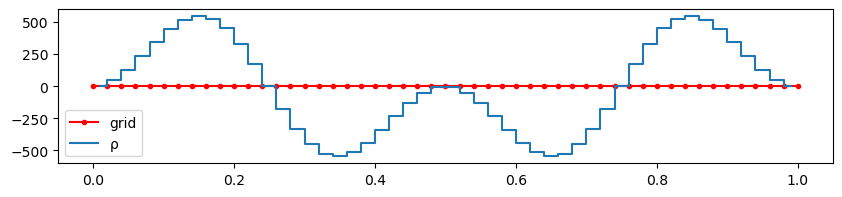

In [6]:
h  = 0.02
xf = 0.0:h:1.0
xc = 0.5 .* xf[1:end-1] .+
     0.5 .* xf[2:end]
φref = @.        cos(2π * 3xc)-9cos(2π * xc)
f(x) = 72.0π^2 * sin(2π * 2x) * sin(2π * x)
ρ = f.(xc)
ρ.-= mean(ρ) # substract mean value as it is a crucial condition

figure(figsize=(10, 2))
plot(xf, zero(xf), "r.-")
step(xc, ρ, where="mid")
legend(["grid", "ρ"]);

The above problem is solved using a Linear Solver. We can apply both periodic and Dirichlet boundary conditions.
In the case of boundary conditions on both boundaries we can impose additional constraint on a mean solution value. This is the reason why we substract the mean solution value after calculating the electric potential.

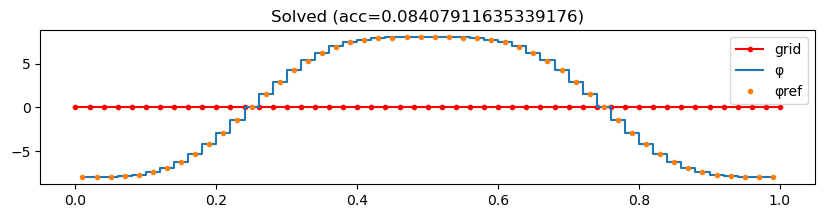

  0.638418 seconds (4.45 M allocations: 232.963 MiB, 7.71% gc time, 99.98% compilation time)


In [7]:
bc = PeriodicBC()
ps = LinearSolver(xf, left=bc, right=bc)
φ  = solution(ps)

@time it = solve!(ps, ρ)
φ.-= mean(φ) # substract mean value when both boundary conditions are periodic

figure(figsize=(10, 2))
title("Solved (acc=$(norm(φ - φref)))")
plot(xf, zero(xf), "r.-")
step(xc, φ, where="mid")
plot(xc, φref, ".")
legend(["grid", "φ", "φref"]);

Once again the same Poisson equation is being solved with periodic boundary conditions on both boundaries. In this case the `solve!` procedure substract the mean value in the end.

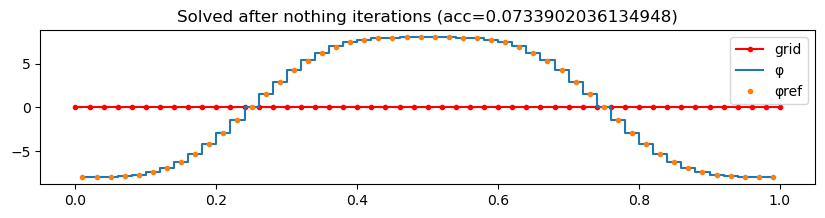

  0.093279 seconds (652.70 k allocations: 34.072 MiB, 10.31% gc time, 99.89% compilation time)


In [8]:
ps = InPlacePeriodicSolver(xf; maxiter=1000)
φ  = solution(ps)

@time it = solve!(ps, ρ)
φ.-= mean(φ) # substract mean value when both boundary conditions are periodic

figure(figsize=(10, 2))
title("Solved after $it iterations (acc=$(norm(φ - φref)))")
plot(xf, zero(xf), "r.-")
step(xc, φ, where="mid")
plot(xc, φref, ".")
legend(["grid", "φ", "φref"]);

Now we can also differentiate the electric potential and obtain the electric field which uses the information about boundaries.

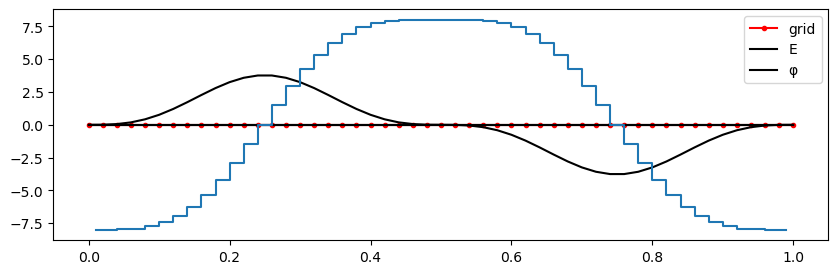

  70.470 ns (1 allocation: 16 bytes)


In [9]:
using BenchmarkTools
E = zeros(SVector{3, Float64}, length(xf));
∇ = gradient(ps)
@btime ∇($φ; result=$E)

figure(figsize=(10, 3))
plot(xf, zero(xf), "r.-")
plot(xf, 0.05E, "k-")
step(xc, φ, where="mid")
legend(["grid", "E", "φ"]);

#### Compare accuracy
Check if the solver is second-order accurate (it is not...)

In [76]:
dbc = DirichletBC()
nbc = NeumannBC()
pbc = PeriodicBC()
L2error = zeros(15)
cellsize = zeros(15)
for i = reverse(1:15)
    n = ceil(Int64, 2^(0.5i + 3))
    xf = range(0.0, 1.0, length=n)
    xc = 0.5 .* xf[1:end-1] .+
         0.5 .* xf[2:end]
    φref = @.        cos(2π * 3xc)-9cos(2π * xc)
    f(x) = 72.0π^2 * sin(2π * 2x) * sin(2π * x)
    ρ = f.(xc)
    ρ.-= mean(ρ) # substract mean value as it is a crucial condition

    ps = LinearSolver(xf, left=pbc, right=pbc)
    φ  = solution(ps)
    solve!(ps, ρ)
    φ.-= mean(φ) # substract mean value when both boundary conditions are periodic

    L2error[i] = norm(φ - φref) / norm(φref)
    cellsize[i] = xf.step
end

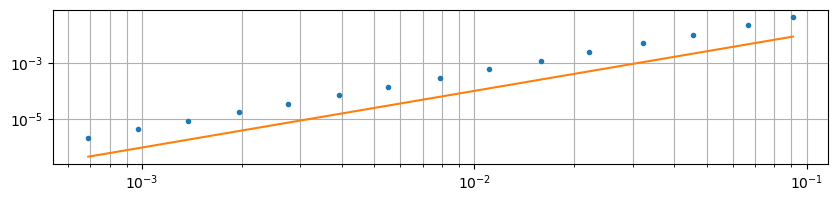

In [80]:
figure(figsize=(10, 2))
loglog(cellsize, L2error, ".")
loglog(cellsize, cellsize .^ 2)
grid(which="both")

In [81]:
ps.A

11×11 SparseMatrixCSC{Float64, Int64} with 33 stored entries:
  2.0  -1.0    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -1.0
 -1.0   2.0  -1.0    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅   -1.0   2.0  -1.0    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅   -1.0   2.0  -1.0    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅   -1.0   2.0  -1.0    ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅   -1.0   2.0  -1.0    ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅   -1.0   2.0  -1.0    ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -1.0   2.0  -1.0    ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -1.0   2.0  -1.0    ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -1.0   2.0  -1.0
 -1.0    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -1.0   2.0

### Two-dimensional Poisson Solver
We will start with a simple example from W. Briggs, V. Henson, and S. McCormick, _Implementation_ in _A multigrid tutorial_, SIAM, 2000, ch. 4, pp. 64-68.

In [83]:
dbc = DirichletBC()
L2error = zeros(15)
cellsize = zeros(15)
for i = 1:15
    n  = ceil(Int64, 2^(1+i/2))
    xf = range(0.0, 1.0, length=n)
    yf = range(0.0, 1.0, length=n)
    xc = 0.5 .* xf[1:end-1] .+
         0.5 .* xf[2:end]
    yc = 0.5 .* yf[1:end-1] .+
         0.5 .* yf[2:end]
    nx = length(xc)
    ny = length(yc)
    xx = repeat(xc,   1, ny)
    yy = repeat(yc', nx,  1)
    f(x, y) = -2((1 - 6x^2) * y^2 * (1 - y^2) +
                 (1 - 6y^2) * x^2 * (1 - x^2))
    ρ = f.(xx, yy)
    φref = @. (xx^2 - xx^4) * (yy^4 - yy^2)
    
    ps = LinearSolver(xf, yf, left=dbc, right=dbc, upper=dbc, lower=dbc)
    solve!(ps, ρ)
    φ  = solution(ps)

    L2error[i] = norm(φ - φref) / norm(φref)
    cellsize[i] = xf.step
end

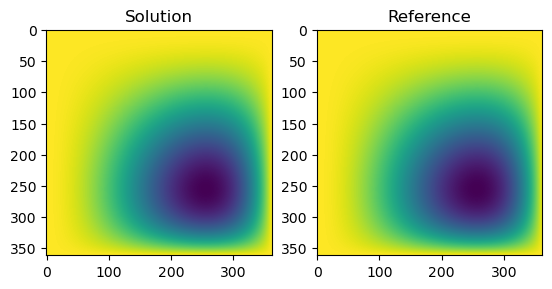

PyObject <matplotlib.image.AxesImage object at 0x16ff5b490>

In [84]:
subplot(1,2,1); title("Solution"); imshow(φ)
subplot(1,2,2); title("Reference");imshow(φref)

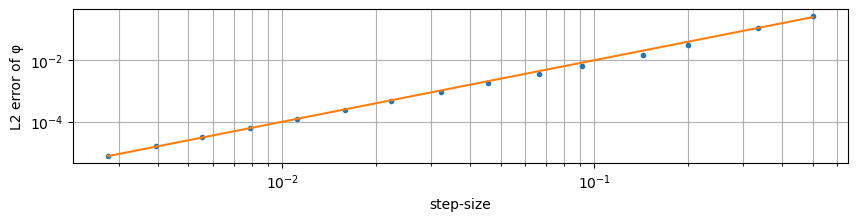

In [86]:
figure(figsize=(10, 2))
loglog(cellsize, L2error, ".")
loglog(cellsize, cellsize.^2)
xlabel("step-size")
ylabel("L2 error of φ")
grid(which="both")

A standard example with simple boundary conditions.

In [91]:
dbc = DirichletBC()
L2error = zeros(15)
L2Error = zeros(15)
cellsize = zeros(15)
for i = 1:15
    n  = ceil(Int64, 2^(1+i/2))
    xf = range(0., 1., length=n)
    yf = range(0., 1., length=n)
    xc = 0.5 .* xf[1:end-1] .+
         0.5 .* xf[2:end]
    yc = 0.5 .* yf[1:end-1] .+
         0.5 .* yf[2:end]
    nx = length(xc)
    ny = length(yc)
    xx = repeat(xc,   1, ny)
    yy = repeat(yc', nx,  1)
    f(x, y) = -sin(2π*x) * sin(2π*y)

    φref = @. 1.0 / 8π^2 * sin(2π*xx) * sin(2π*yy)
    ρ = f.(xx, yy)
    @show h = 1.0 / n
    ps = LinearSolver(xf, yf, left=dbc, right=dbc, upper=dbc, lower=dbc)
    solve!(ps, ρ)
    φ  = solution(ps)

    L2error[i] = norm(φ - φref) / norm(φref)
    cellsize[i] = xf.step
end

h = 1.0 / n = 0.3333333333333333
h = 1.0 / n = 0.25
h = 1.0 / n = 0.16666666666666666
h = 1.0 / n = 0.125
h = 1.0 / n = 0.08333333333333333
h = 1.0 / n = 0.0625
h = 1.0 / n = 0.043478260869565216
h = 1.0 / n = 0.03125
h = 1.0 / n = 0.021739130434782608
h = 1.0 / n = 0.015625
h = 1.0 / n = 0.01098901098901099
h = 1.0 / n = 0.0078125
h = 1.0 / n = 0.005494505494505495
h = 1.0 / n = 0.00390625
h = 1.0 / n = 0.0027548209366391185


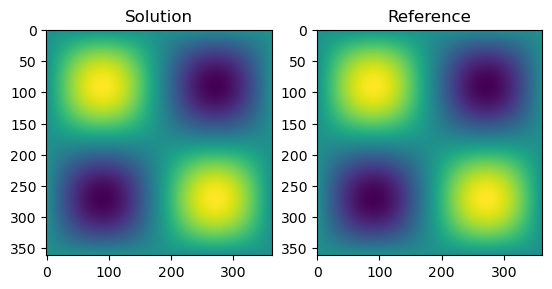

PyObject <matplotlib.image.AxesImage object at 0x2a7663580>

In [92]:
subplot(1,2,1); title("Solution"); imshow(φ)
subplot(1,2,2); title("Reference");imshow(φref)

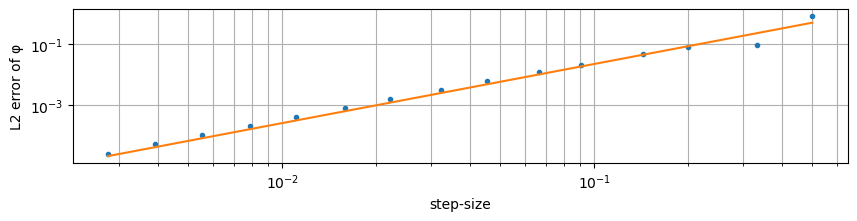

In [97]:
figure(figsize=(10, 2))
loglog(cellsize, L2error, ".")
loglog(cellsize, 2cellsize.^1.95)
xlabel("step-size")
ylabel("L2 error of φ")
grid(which="both")

Another example is from M. Duarte, Z. Bonaventura, M. Massot, and A. Bourdon, _A numerical strategy to discretize and solve the Poisson equation on dynamically adapted multiresolution grids for time-dependent streamer discharge simulations_, 2015

It compares both the electrostatic potential and the electric field.

Because _pole_ does supports only constant values at each boundary, we have fixed the boundary cells according to the known solution. This is also the reason that the electric field in compared only at the faces **inside** the domain.

In [99]:
gradient2(ps::LinearSolver) = GradientOperator2(ps.n[1], ps.n[2], ps.δ[1],  ps.δ[2], ps.bcs)

gradient2 (generic function with 1 method)

In [104]:
nbc = NeumannBC()
L2error = zeros(14)
L2Error = zeros(14)
cellsize = zeros(14)
for i = 1:14
    n  = ceil(Int64, 2^(2+i/2))
    xf = range(-0.5, +0.5, length=n)
    yf = range(-0.5, +0.5, length=n)
    xc = 0.5 .* xf[1:end-1] .+
         0.5 .* xf[2:end]
    yc = 0.5 .* yf[1:end-1] .+
         0.5 .* yf[2:end]
    nx = length(xc)
    ny = length(yc)
    xx = repeat(xc,   1, ny)
    yy = repeat(yc', nx,  1)
    a, b, σ = 10, 0, 0.05
    g(x, y) = a*exp(-(x^2 + y^2)/σ^2)
    f(x, y) =(4.0/σ^2) * ((x^2 + y^2)/σ^2 - 1.0) * g(x, y)

    φref = @. g(xx, yy) + b
    ρ = f.(xx, yy)
    @show h = 1.0 / n
    ps = LinearSolver(xf, yf, left=nbc, right=nbc, upper=nbc, lower=nbc)
    ############ I cheat a little bit here, as the boundary cells have prescribed values
    for i=1:nx, j=(1, ny)
        fixed!(ps, φref[i,j], i, j)
    end
    for i=(1,nx), j=2:ny-1
        fixed!(ps, φref[i,j], i, j)
    end
    ############
    solve!(ps, ρ)
    φ  = solution(ps)
    
    ∇ = gradient2(ps)
    E = ∇(φ)
    Ex = [-E[i,j][1] for i=2:nx, j=2:ny-1]
    Exref = [2.0 * xf[i] * g(xf[i], yc[j]) / σ^2 for i=2:nx, j=2:ny-1]

    L2error[i] = norm(φ - φref) / norm(φref)
    L2Error[i] = norm(Ex - Exref) / norm(Exref)
    cellsize[i] = xf.step
end

h = 1.0 / n = 0.16666666666666666
h = 1.0 / n = 0.125
h = 1.0 / n = 0.08333333333333333
h = 1.0 / n = 0.0625
h = 1.0 / n = 0.043478260869565216
h = 1.0 / n = 0.03125
h = 1.0 / n = 0.021739130434782608
h = 1.0 / n = 0.015625
h = 1.0 / n = 0.01098901098901099
h = 1.0 / n = 0.0078125
h = 1.0 / n = 0.005494505494505495
h = 1.0 / n = 0.00390625
h = 1.0 / n = 0.0027548209366391185
h = 1.0 / n = 0.001953125


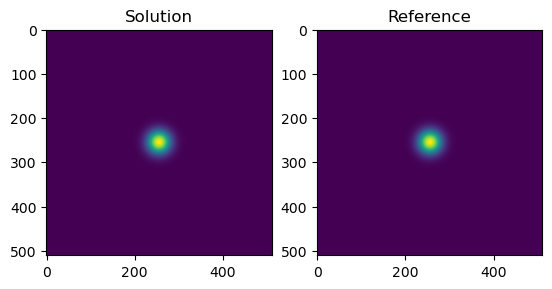

PyObject <matplotlib.image.AxesImage object at 0x2b0344040>

In [105]:
subplot(1,2,1); title("Solution"); imshow(φ); clim(extrema(φref))
subplot(1,2,2); title("Reference");imshow(φref)

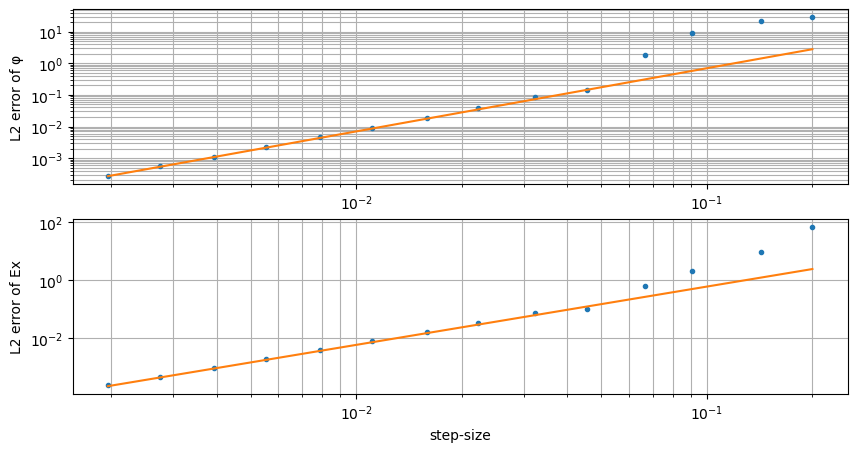

In [112]:
figure(figsize=(10, 5))
subplot(2,1,1)
loglog(cellsize, L2error, ".")
loglog(cellsize, 7e1cellsize.^2)
xlabel("step-size")
ylabel("L2 error of φ")
grid(which="both")

subplot(2,1,2)
loglog(cellsize, L2Error, ".")
loglog(cellsize, 6e1cellsize.^2)
xlabel("step-size")
ylabel("L2 error of Ex")
grid(which="both")

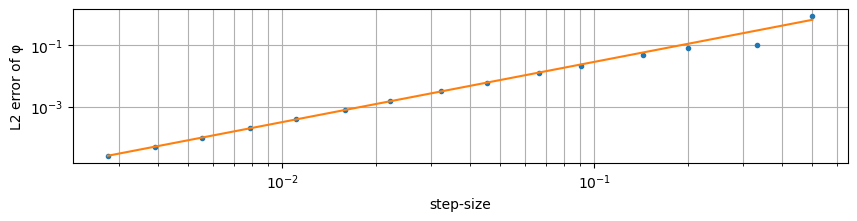

h = 1.0 / n = 0.3333333333333333
h = 1.0 / n = 0.25
h = 1.0 / n = 0.16666666666666666
h = 1.0 / n = 0.125
h = 1.0 / n = 0.08333333333333333
h = 1.0 / n = 0.0625
h = 1.0 / n = 0.043478260869565216
h = 1.0 / n = 0.03125
h = 1.0 / n = 0.021739130434782608
h = 1.0 / n = 0.015625
h = 1.0 / n = 0.01098901098901099
h = 1.0 / n = 0.0078125
h = 1.0 / n = 0.005494505494505495
h = 1.0 / n = 0.00390625
h = 1.0 / n = 0.0027548209366391185


In [120]:
dbc = DirichletBC()
L2error = zeros(15)
L2Error = zeros(15)
cellsize = zeros(15)
for i = 1:15
    n  = ceil(Int64, 2^(1+i/2))
    xf = range(0., 1., length=n)
    xc = 0.5 .* xf[1:end-1] .+
         0.5 .* xf[2:end]
    nx = length(xc)
    f(x) = -sin(2π*x)

    φref = @. 1.0 / 4π^2 * sin(2π*xc)
    ρ = f.(xc)
    @show h = 1.0 / n
    ps = LinearSolver(xf, left=dbc, right=dbc)
    solve!(ps, ρ)
    φ  = solution(ps)

    L2error[i] = norm(φ - φref) / norm(φref)
    cellsize[i] = xf.step
end

figure(figsize=(10, 2))
loglog(cellsize, L2error, ".")
loglog(cellsize, 2.5cellsize .^ 1.95)
xlabel("step-size")
ylabel("L2 error of φ")
grid(which="both")

In [121]:
L2error = zeros(17)
L2Error = zeros(17)
cellsize = zeros(17)
for i = 1:17
    n  = ceil(Int64, 2^(2+i/2))
    xf = range(-.5, +.5, length=n)
    xc = 0.5 .* xf[1:end-1] .+
         0.5 .* xf[2:end]
    nx = length(xc)
    a, b, σ = 10, 0, 0.01
    g(x) = a*exp(-x^2/σ^2)
    f(x) =(4.0/σ^2) * (x^2/σ^2 - 0.5) * g(x)

    φref = @. g(xc) + b
    ρ = f.(xc)
    @show h = 1.0 / n
    ps = LinearSolver(xf, left=DirichletBC(g(-.5)), right=DirichletBC(g(+.5)))
    solve!(ps, ρ)
    φ  = solution(ps)
    
    #∇ = gradient(ps)
    #E = ∇(φ)
    #Ex = [-E[i,j][1] for i=2:nx, j=2:ny-1]
    #Exref = [2.0 * xf[i] * g(xf[i]) / σ^2 for i=2:nx, j=2:ny-1]

    L2error[i] = norm(φ - φref) ./ norm(φref)
    #L2Error[i] = norm(Ex - Exref)
    cellsize[i] = xf.step
end

h = 1.0 / n = 0.16666666666666666
h = 1.0 / n = 0.125
h = 1.0 / n = 0.08333333333333333
h = 1.0 / n = 0.0625
h = 1.0 / n = 0.043478260869565216
h = 1.0 / n = 0.03125
h = 1.0 / n = 0.021739130434782608
h = 1.0 / n = 0.015625
h = 1.0 / n = 0.01098901098901099
h = 1.0 / n = 0.0078125
h = 1.0 / n = 0.005494505494505495
h = 1.0 / n = 0.00390625
h = 1.0 / n = 0.0027548209366391185
h = 1.0 / n = 0.001953125
h = 1.0 / n = 0.001379310344827586
h = 1.0 / n = 0.0009765625
h = 1.0 / n = 0.0006901311249137336


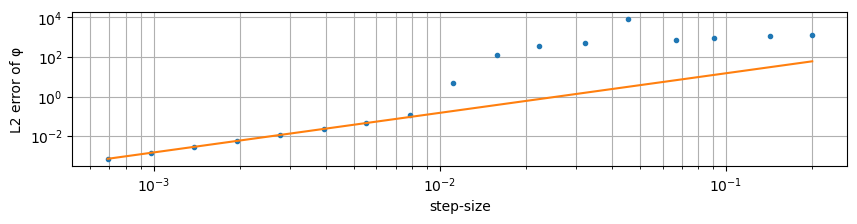

In [126]:
figure(figsize=(10, 2))
loglog(cellsize, L2error, ".")
loglog(cellsize, 1.5e3cellsize .^ (2))
xlabel("step-size")
ylabel("L2 error of φ")
grid(which="both")

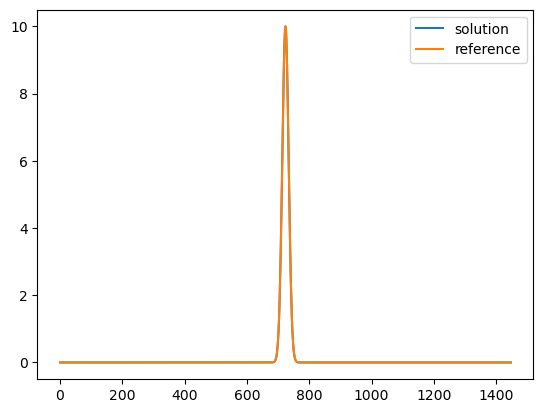

PyObject <matplotlib.legend.Legend object at 0x16fe38790>

In [127]:
plot(φ)
plot(φref)
legend(("solution", "reference"))